## CISC 886 Cloud Computing/ Big Data W23:
### Final project: customer segmentation.
* Spark is used to analyze customer data and segment customers based on their behavior, demographics, and other characteristics.
* This can be used to personalize marketing campaigns and improve customer retention.
--------------------------------------------------------------------------------
### Dataset description:
* Data used from: https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m
* The dataset provides a comprehensive analysis of customer data from a consumer credit card portfolio, aiming to predict customer attrition. It includes demographic details, relationship with the provider, spending behavior, and metrics like total revolving balance, credit limit, and average open to buy rate. This data can help determine long-term account stability or potential departure, enabling better portfolio management or customer service.
--------------------------------------------------------------------------------




In [ ]:
import findspark
findspark.init()
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O.
import os
sns.set()
# some important libraries that is requried.
from pyspark.ml import Pipeline
import warnings
warnings.filterwarnings('ignore')
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import pyspark # only run after findspark.init()
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import when, count, isnull,isnan
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import col, countDistinct
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.evaluation import ClusteringEvaluator
# import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data from CSV

In [ ]:
# Reading data from a CSV file using Spark DataFrame
data = spark.read.options(header='True', inferSchema='True', delimiter=',') \
  .csv("BankChurners.csv")

In [ ]:
# Display the first 5 rows of the 'data'
def printdf(data, l=5):
    return data.limit(l).toPandas()

printdf(data)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [ ]:
# Display the schema of the 'data' DataFrame
data.printSchema()

root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (n

## Data Preparation and Cleaning

In [ ]:
print(f'Number of rows and column in dataframe: {data.toPandas().shape}')

Number of rows and column in dataframe: (10127, 23)


In [ ]:
#Summary Statistics
numeric_features = [t[0] for t in data.dtypes if t[1] == 'int' or t[1] == 'double']
data.describe(numeric_features).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CLIENTNUM,10127,7.391776063336625E8,3.690378345023116E7,708082083,828343083
Customer_Age,10127,46.32596030413745,8.016814032549046,26,73
Dependent_count,10127,2.3462032191172115,1.29890834890379,0,5
Months_on_book,10127,35.928409203120374,7.98641633087208,13,56
Total_Relationship_Count,10127,3.8125802310654686,1.55440786533883,1,6
Months_Inactive_12_mon,10127,2.3411671768539546,1.0106223994182844,0,6
Contacts_Count_12_mon,10127,2.4553174681544387,1.1062251426359249,0,6
Credit_Limit,10127,8631.953698034848,9088.776650223148,1438.3,34516.0
Total_Revolving_Bal,10127,1162.8140614199665,814.9873352357533,0,2517


In [ ]:
# Retrieve distinct values from the 'Attrition_Flag' column in the 'data' DataFrame
data.select('Attrition_Flag').distinct().collect()

[Row(Attrition_Flag='Existing Customer'),
 Row(Attrition_Flag='Attrited Customer')]

In [ ]:
# Grouping data by 'Attrition_Flag', calculating sums, and transposing the result
data.groupBy("Attrition_Flag").sum().toPandas().transpose()

,0,1
Attrition_Flag,Existing Customer,Attrited Customer
sum(CLIENTNUM),6289381352025,1196270267316
sum(Customer_Age),393228,75915
sum(Dependent_count),19851,3909
sum(Months_on_book),304985,58862
sum(Total_Relationship_Count),33274,5336
sum(Months_Inactive_12_mon),19327,4382
sum(Contacts_Count_12_mon),20029,4836
sum(Credit_Limit),74178458.899999,13237336.2
sum(Total_Revolving_Bal),10681135,1094683


In [ ]:
# Grouping data by 'Attrition_Flag', aggregating sum of 'Total_Revolving_Bal' and maximum of 'Credit_Limit', and displaying the result
data.groupBy("Attrition_Flag").agg({"Total_Revolving_Bal": "sum", "Credit_Limit": "max"}).show()

+-----------------+-----------------+------------------------+
|   Attrition_Flag|max(Credit_Limit)|sum(Total_Revolving_Bal)|
+-----------------+-----------------+------------------------+
|Existing Customer|          34516.0|                10681135|
|Attrited Customer|          34516.0|                 1094683|
+-----------------+-----------------+------------------------+



In [ ]:
# Counting missing values (null and NaN) for each column in the 'data' DataFrame and transposing the result
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns] ).toPandas().transpose()

,0
CLIENTNUM,0
Attrition_Flag,0
Customer_Age,0
Gender,0
Dependent_count,0
Education_Level,0
Marital_Status,0
Income_Category,0
Card_Category,0
Months_on_book,0


In [ ]:
# Remove duplicate entries from people_df_sub
df = data.dropDuplicates()

# Count the number of rows
print("There were {} rows before removing duplicates,\
       and {} rows after removing duplicates".format(df.count(),
                                                     df.count()))

There were 10127 rows before removing duplicates,       and 10127 rows after removing duplicates


## Feature Engineering

In [ ]:
def indexing (df, inputCol, outputCol):
    """
    Perform indexing on a DataFrame column.
    Args:
        df (DataFrame): The input DataFrame.
        inputCol (str): The name of the column to be indexed.
        outputCol (str): The name of the output indexed column.
    Returns:
        DataFrame: The input DataFrame with the indexed column added.
    """
    indexer = StringIndexer(inputCol=inputCol, outputCol=outputCol)
    indexed = indexer.fit(df).transform(df)
    return indexed

In [ ]:
# Indexing several columns in the DataFrame and displaying the result
indexed = indexing (df, "Attrition_Flag", "Attrition_Flag_Index")
indexed = indexing (indexed, "Gender", "Gender_Index")
indexed = indexing (indexed, "Education_Level", "Education_Level_Index")
indexed = indexing (indexed, "Marital_Status", "Marital_Status_Index")
indexed = indexing (indexed, "Income_Category", "Income_Category_Index")
indexed = indexing (indexed, "Card_Category", "Card_Category_Index")
printdf(indexed)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Attrition_Flag_Index,Gender_Index,Education_Level_Index,Marital_Status_Index,Income_Category_Index,Card_Category_Index
0,789124683,Existing Customer,54,M,2,Unknown,Married,$80K - $120K,Blue,42,...,0.750,0.000,0.000210,0.999790,0.0,1.0,2.0,0.0,2.0,0.0
1,717296808,Existing Customer,67,F,1,Graduate,Married,Less than $40K,Blue,56,...,1.000,0.837,0.000169,0.999830,0.0,0.0,0.0,0.0,0.0,0.0
2,711551958,Attrited Customer,59,M,2,Post-Graduate,Married,$60K - $80K,Blue,46,...,0.500,0.000,0.997200,0.002801,1.0,1.0,5.0,0.0,3.0,0.0
3,713441958,Existing Customer,46,M,2,High School,Married,$120K +,Blue,36,...,0.786,0.090,0.000175,0.999830,0.0,1.0,1.0,0.0,5.0,0.0
4,789513858,Attrited Customer,43,M,3,Unknown,Married,$40K - $60K,Blue,35,...,0.400,0.000,0.995440,0.004558,1.0,1.0,2.0,0.0,1.0,0.0


In [ ]:
# Separating features (X) and target (y) from the indexed DataFrame
X = indexed.drop('Attrition_Flag', 'Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category')
y = indexed['Attrition_Flag']

In [ ]:
vecAssembler = VectorAssembler(outputCol="features")

In [ ]:
vecAssembler.setInputCols (['Customer_Age', 'Gender_Index','Avg_Open_To_Buy', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct'])

VectorAssembler_9589c4aa8193

In [ ]:
transformed_X = vecAssembler.transform(X)

In [ ]:
printdf(transformed_X)

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Attrition_Flag_Index,Gender_Index,Education_Level_Index,Marital_Status_Index,Income_Category_Index,Card_Category_Index,features
0,789124683,54,2,42,4,2,3,12217.0,0,12217.0,...,0.000,0.000210,0.999790,0.0,1.0,2.0,0.0,2.0,0.0,"[54.0, 1.0, 12217.0, 12217.0, 1110.0, 21.0]"
1,717296808,67,1,56,4,3,2,3006.0,2517,489.0,...,0.837,0.000169,0.999830,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 0.0, 489.0, 3006.0, 1661.0, 32.0]"
2,711551958,59,2,46,3,3,3,1438.3,0,1438.3,...,0.000,0.997200,0.002801,1.0,1.0,5.0,0.0,3.0,0.0,"[59.0, 1.0, 1438.3, 1438.3, 844.0, 24.0]"
3,713441958,46,2,36,5,3,2,19727.0,1785,17942.0,...,0.090,0.000175,0.999830,0.0,1.0,1.0,0.0,5.0,0.0,"[46.0, 1.0, 17942.0, 19727.0, 1245.0, 25.0]"
4,789513858,43,3,35,2,2,3,1438.3,0,1438.3,...,0.000,0.995440,0.004558,1.0,1.0,2.0,0.0,1.0,0.0,"[43.0, 1.0, 1438.3, 1438.3, 891.0, 28.0]"


## Setup and Train Model

In [ ]:
# Applying K-Means clustering to the transformed feature data
k_means = KMeans(featuresCol='features', k=4)
model = k_means.fit(transformed_X)
predictions = model.transform(transformed_X)

In [ ]:
# Selecting 'CLIENTNUM' and 'prediction' columns from the predictions DataFrame and displaying the result
result = predictions.select('CLIENTNUM', 'prediction')
printdf(result)

,CLIENTNUM,prediction
0,789124683,2
1,717296808,0
2,711551958,0
3,713441958,2
4,789513858,0


In [ ]:
# Creating a VectorAssembler to transform selected features into a single feature vector
vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols (['Customer_Age', 'Gender_Index','Avg_Open_To_Buy', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Card_Category_Index'])
transformed_X2 = vecAssembler.transform(X)

In [ ]:
# Applying K-Means clustering to transformed feature data with specified parameters
k_means = KMeans(featuresCol='features', maxIter=50, k=4)
model = k_means.fit(transformed_X)
predictions = model.transform(transformed_X)
result = predictions.select('CLIENTNUM', 'prediction')
printdf(result)

,CLIENTNUM,prediction
0,789124683,2
1,717296808,0
2,711551958,0
3,713441958,2
4,789513858,0


## Model Evaluation

### Principle Component Analysis

In [ ]:
# Performing Principal Component Analysis (PCA) on transformed feature data
pca = PCAml(k=3, inputCol="features", outputCol="pca")
pca_model = pca.fit(transformed_X2)
pca_transformed = pca_model.transform(transformed_X2)

In [ ]:
# extract principle components
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [ ]:
# retrieve cluster assignments from k-means assignments
cluster_assignment = np.array(predictions.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

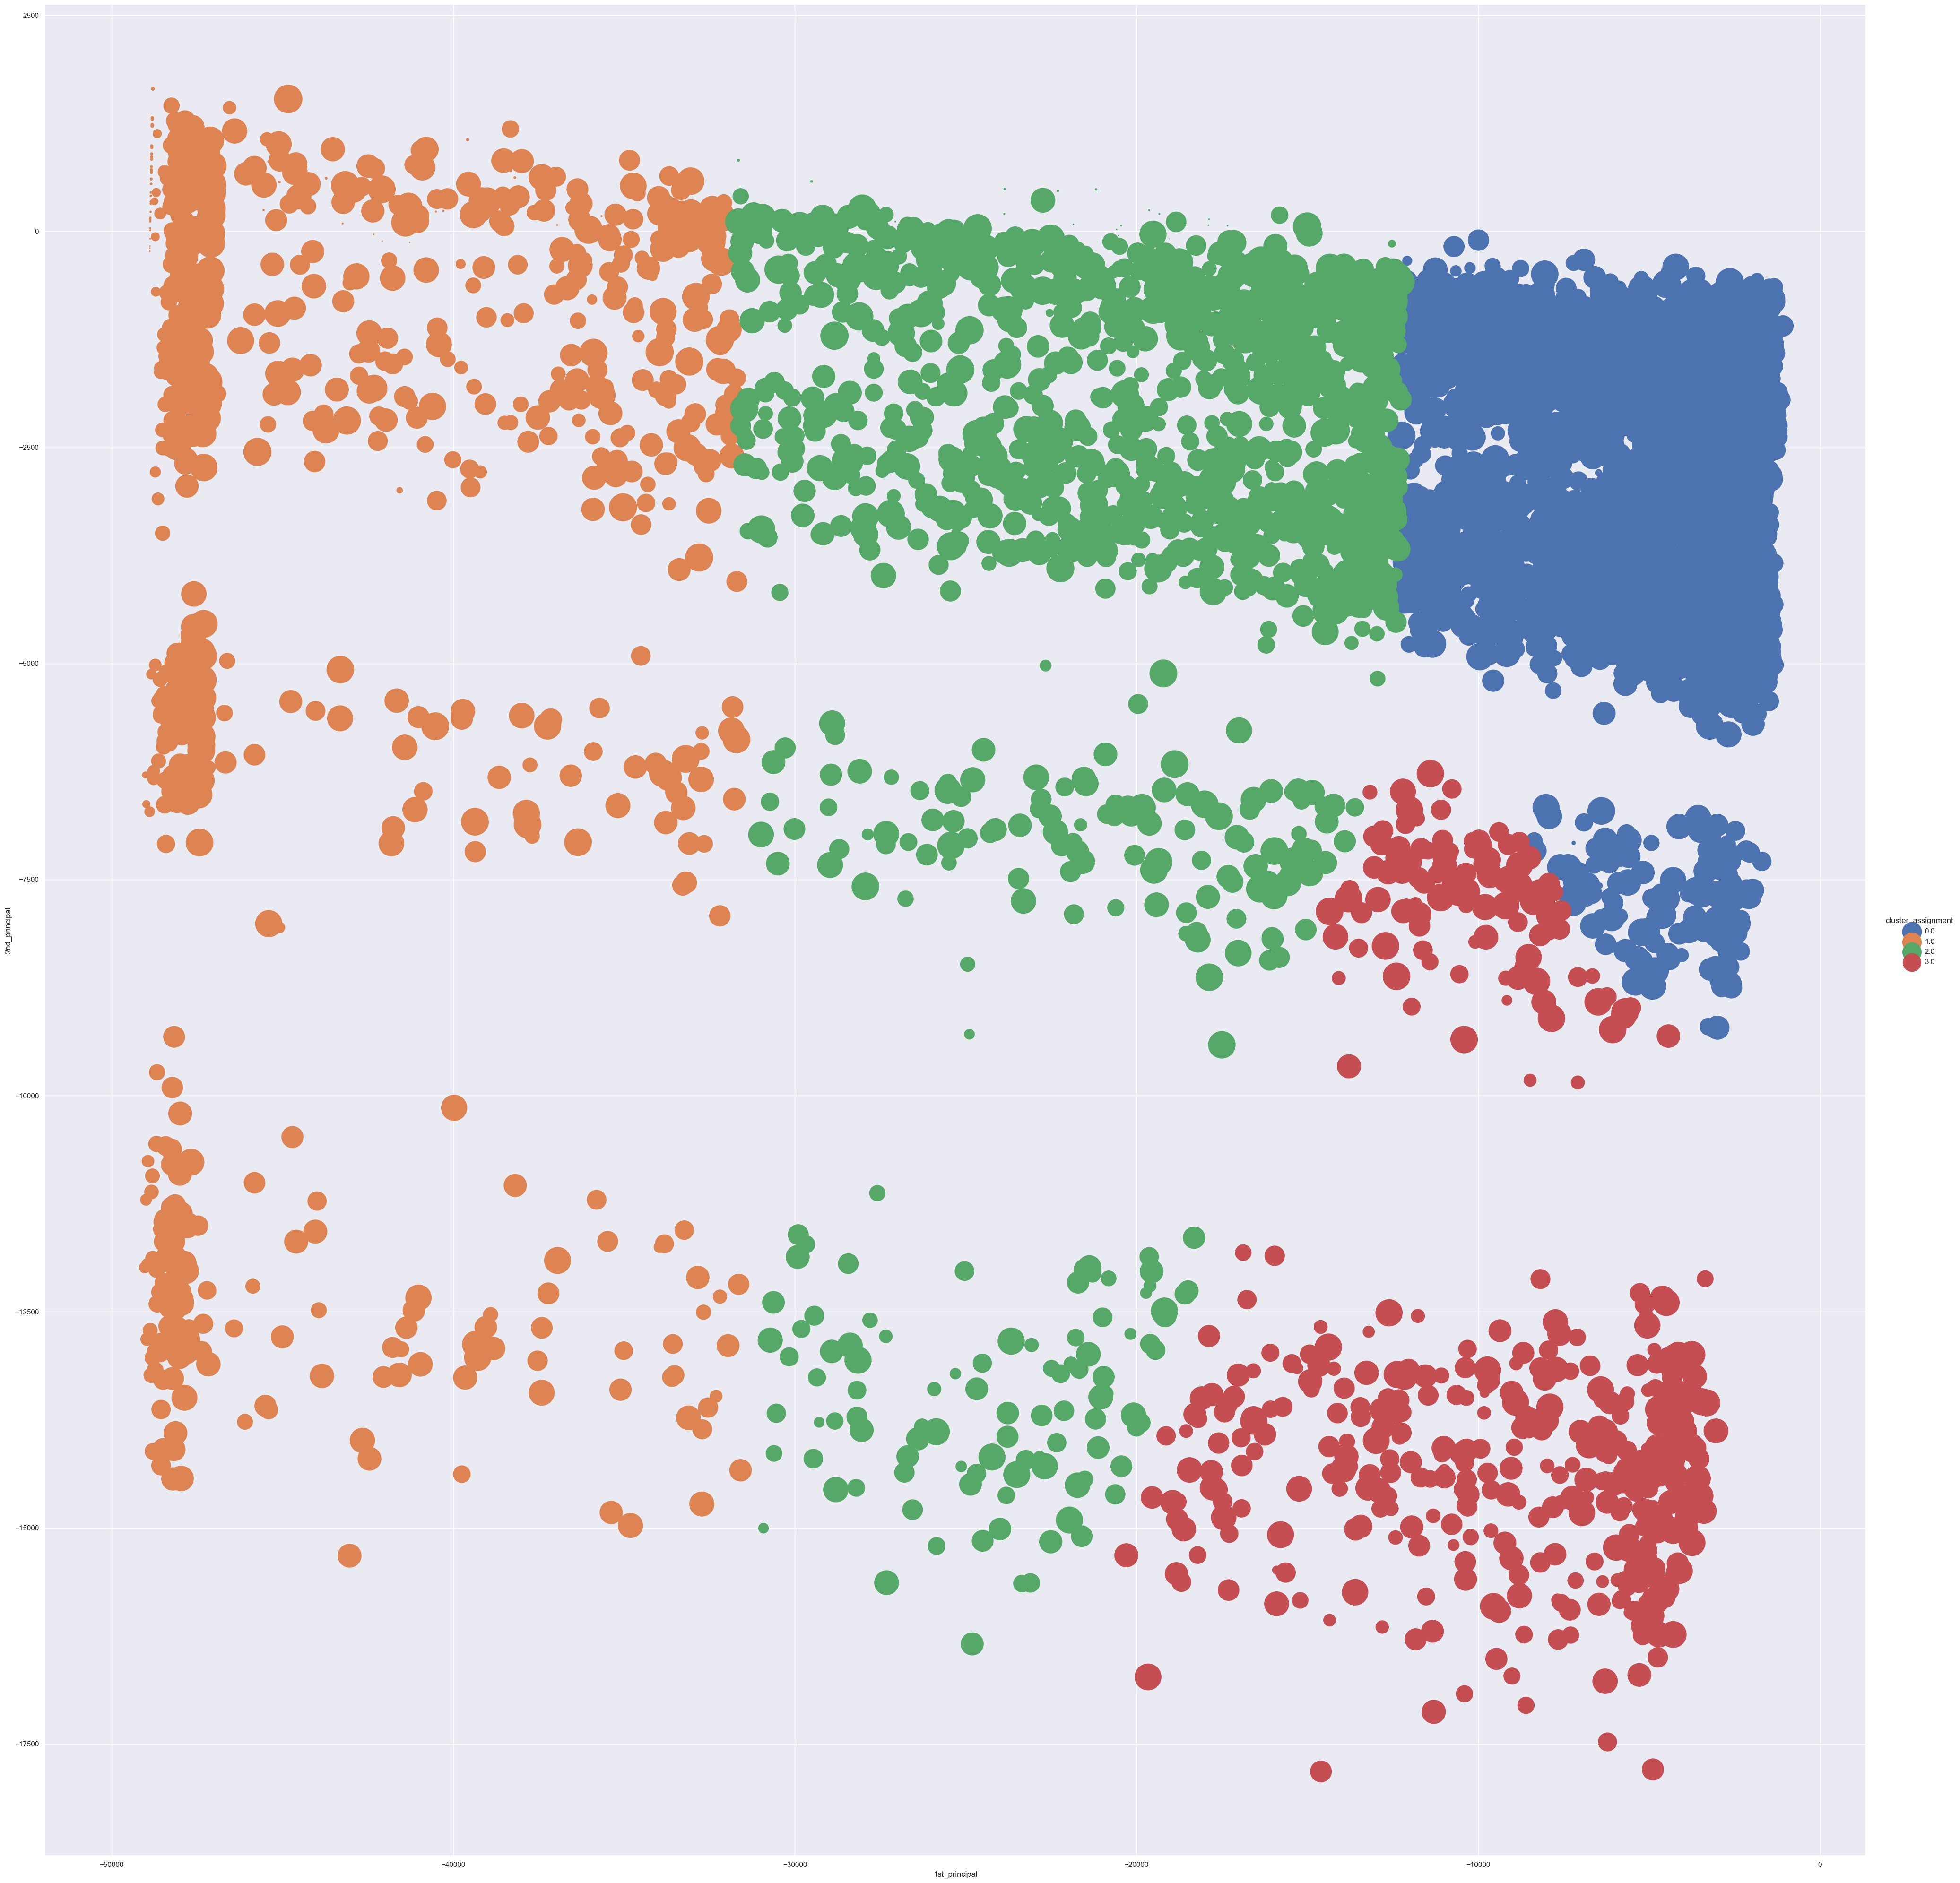

In [ ]:
# plot the principle components
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","3nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=40).map(plt.scatter, '1st_principal', '2nd_principal', "3nd_principal" ).add_legend()

plt.show()

### Silhouette Coefficient

In [ ]:
# Evaluating K-Means clustering using the Silhouette score
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
evaluation_score=evaluator.evaluate(predictions)
print(evaluation_score)

0.755350586635849
